In [16]:
import os
import glob
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

NORMAL_DIR = '/Brain_Data_Organised/Normal'
STROKE_DIR = '/Brain_Data_Organised/Stroke'
BATCH_SIZE = 16
LR = 1e-4
EPOCHS = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_CLASSES = 1 

image_paths = []
labels = []

for ext in ('*.jpg', '*.jpeg', '*.JPG', '*.JPEG'):
    for img_file in glob.glob(os.path.join(NORMAL_DIR, ext)):
        image_paths.append(img_file)
        labels.append(0)
    for img_file in glob.glob(os.path.join(STROKE_DIR, ext)):
        image_paths.append(img_file)
        labels.append(1)

print(f"Найдено {len(image_paths)} изображений") 


train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.1, random_state=42, stratify=labels
)

class StrokeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img, label.unsqueeze(0)  # выход (1,)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = StrokeDataset(train_paths, train_labels, transform=transform)
val_dataset = StrokeDataset(val_paths, val_labels, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for imgs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs, targets = imgs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    epoch_loss = running_loss / len(train_dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, targets in val_loader:
            imgs, targets = imgs.to(DEVICE), targets.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * imgs.size(0)
    val_loss /= len(val_dataset)
    print(f"Epoch {epoch+1}: Train Loss={epoch_loss:.4f}, Val Loss={val_loss:.4f}")

torch.save(model.state_dict(), 'stroke_classifier_resnet18.pth')
print("Обучение завершено. Модель сохранена как stroke_classifier_resnet18.pth")


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Найдено 2501 изображений


Epoch 1/10: 100%|██████████| 141/141 [02:49<00:00,  1.20s/it]


Epoch 1: Train Loss=0.3727, Val Loss=0.2334


Epoch 2/10: 100%|██████████| 141/141 [03:11<00:00,  1.36s/it]


Epoch 2: Train Loss=0.0799, Val Loss=0.1568


Epoch 3/10: 100%|██████████| 141/141 [03:15<00:00,  1.39s/it]


Epoch 3: Train Loss=0.0459, Val Loss=0.1751


Epoch 4/10: 100%|██████████| 141/141 [03:19<00:00,  1.41s/it]


Epoch 4: Train Loss=0.0542, Val Loss=0.0394


Epoch 5/10: 100%|██████████| 141/141 [03:19<00:00,  1.42s/it]


Epoch 5: Train Loss=0.0554, Val Loss=0.0288


Epoch 6/10: 100%|██████████| 141/141 [03:22<00:00,  1.44s/it]


Epoch 6: Train Loss=0.0211, Val Loss=0.0123


Epoch 7/10: 100%|██████████| 141/141 [03:21<00:00,  1.43s/it]


Epoch 7: Train Loss=0.0300, Val Loss=0.0227


Epoch 8/10: 100%|██████████| 141/141 [03:20<00:00,  1.42s/it]


Epoch 8: Train Loss=0.0191, Val Loss=0.0473


Epoch 9/10: 100%|██████████| 141/141 [03:23<00:00,  1.44s/it]


Epoch 9: Train Loss=0.0164, Val Loss=0.0219


Epoch 10/10: 100%|██████████| 141/141 [03:27<00:00,  1.47s/it]


Epoch 10: Train Loss=0.0103, Val Loss=0.1422
Обучение завершено. Модель сохранена как stroke_classifier_resnet18.pth


In [12]:
import torch
from torchvision import transforms, models
from PIL import Image
import torch.nn as nn

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_PATH = 'stroke_classifier_resnet18.pth'
IMG_PATH = '/Users/dmitryfateev/Desktop/ai/test2.jpg'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

img = Image.open(IMG_PATH).convert('RGB')
img_tensor = transform(img).unsqueeze(0).to(DEVICE)  

model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, 1)  
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model = model.to(DEVICE)
model.eval()

with torch.no_grad():
    output = model(img_tensor)
    probability = torch.sigmoid(output).item()

threshold = 0.5 
prediction = 'Инсульт' if probability >= threshold else 'Норма'
print(f'Вероятность инсульта: {probability:.4f} → {prediction}')


Вероятность инсульта: 0.8794 → Инсульт


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


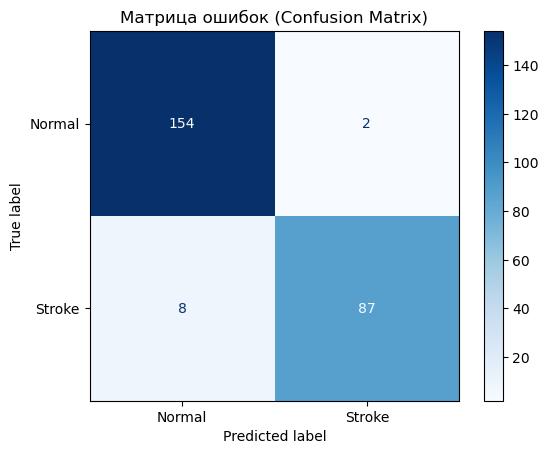

In [17]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision import models, transforms
from PIL import Image
import os
import glob

NORMAL_DIR = '/Users/dmitryfateev/Desktop/ai/Brain_Data_Organised/Normal'
STROKE_DIR = '/Users/dmitryfateev/Desktop/ai/Brain_Data_Organised/Stroke'
BATCH_SIZE = 16
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_CLASSES = 1

class StrokeDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img, label.unsqueeze(0)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image_paths, labels = [], []
for ext in ('*.jpg', '*.jpeg', '*.JPG', '*.JPEG'):
    for img_file in glob.glob(os.path.join(NORMAL_DIR, ext)):
        image_paths.append(img_file)
        labels.append(0)
    for img_file in glob.glob(os.path.join(STROKE_DIR, ext)):
        image_paths.append(img_file)
        labels.append(1)

from sklearn.model_selection import train_test_split
_, val_paths, _, val_labels = train_test_split(
    image_paths, labels, test_size=0.1, random_state=42, stratify=labels
)
val_dataset = StrokeDataset(val_paths, val_labels, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
model.load_state_dict(torch.load('stroke_classifier_resnet18.pth', map_location=DEVICE))
model = model.to(DEVICE)
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for imgs, targets in val_loader:
        imgs = imgs.to(DEVICE)
        targets = targets.to(DEVICE)
        outputs = model(imgs)
        preds = (torch.sigmoid(outputs) > 0.5).int().cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(targets.int().cpu().numpy())

cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Stroke"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Матрица ошибок (Confusion Matrix)")
plt.show()
